IMPORT RELEVANT LIBRARIES

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from scipy import misc
import json
import numpy as np
import cv2
import os
import imageio
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.transforms import Resize, ToTensor
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -uq "/content/drive/My Drive/AC-Dataset/acid-dataset-training.zip" -d "/content/drive/My Drive/input/acid-dataset-training"
#!unzip -uq "/content/drive/My Drive/AC-Dataset/acid-dataset-validation.zip" -d "/content/drive/My Drive/input/acid-dataset-validation"

# Dataset class for both image and mask. 
This makes it easy to load the data in batches during training

In [ ]:
class Wheat(Dataset):
    def __init__(self, mode='train'):
        self.mode = mode
        if self.mode=='train':
            self.path = '/content/drive/My Drive/input/acid-dataset-training/wheat2017'
        elif self.mode=='val':
            self.path = '/content/drive/My Drive/input/acid-dataset-validation/wheat2017'
        else:
            print('mode should be either train or val!')
        self.namelist = os.listdir(self.path)
        
    def __getitem__(self, index):
        name = self.namelist[index]
        img, mask = self.read_img_mask(name)
        img = cv2.resize(img, dsize=(400, 400)) #, interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask, dsize=(400,400)) #, interpolation=cv2.INTER_CUBIC)
        aug = transforms.Compose([transforms.ToTensor()]) # transform img to tensor in range [0,1]
        img, mask = aug(img), aug(mask)
        return img , mask
    
    def __len__(self):
        return len(self.namelist)
    
    def read_img_mask(self, name):
        img = imageio.imread('%s/%s/%s.jpg'%(self.path, name, name))
      
        json_data = json.load(open('%s/%s/%s.json'%(self.path, name, name),'r'))
        mask = np.zeros(img.shape, np.uint8)
        
        for each in json_data['data']:
            name = each['Name']
            if name=='Awns': continue
            Type = each['Type']
            points = [tuple(map(lambda x: int(float(x)), p.split(','))) for p in each['Points']]
            color = (0,255,0) if name=='Ear' else (0,255,0)
            point_size = 2
            thickness = 2
            if Type=='Point':
                for p in points:
                    cv2.circle(mask, p, point_size, color, thickness)
            else:
                cv2.polylines(mask, [np.array(points)], False, color, thickness)

        mask = imageio.imwrite('mask.png', mask)
        mask = imageio.imread('mask.png')
        return img, mask
        
dataset = Wheat('train') # dataset for train set 

# a random pair
img, mask = dataset[np.random.randint(0, len(dataset))]
img.shape, mask.shape

(torch.Size([3, 400, 400]), torch.Size([3, 400, 400]))

# Example image and mask

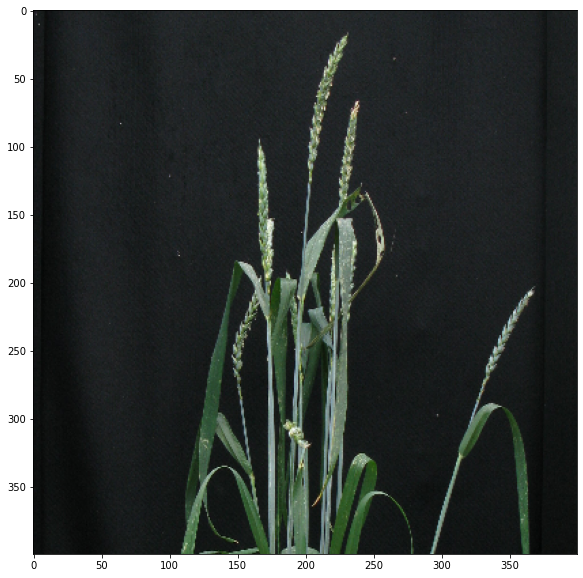

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img.permute(1, 2, 0))

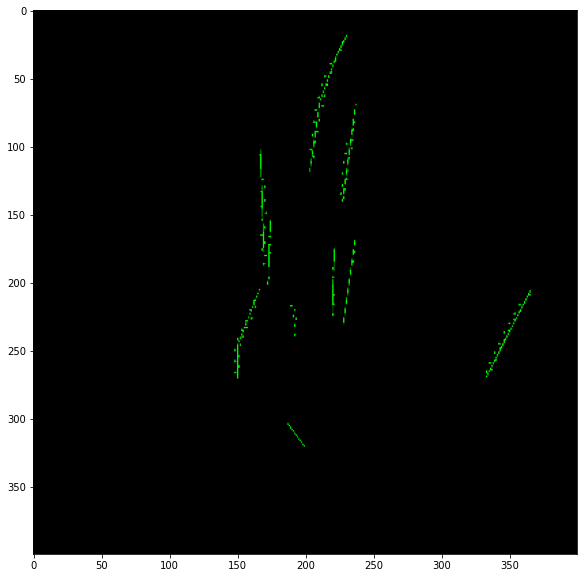

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(mask.permute(1, 2, 0))

# Defining the dataloader for the wheat dataset

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
train_indices = torch.LongTensor(100).random_(0, 415)
val_indices = torch.LongTensor(30).random_(0, 415)

train_loader = DataLoader(Wheat('train'), batch_size=8, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(Wheat('train'), batch_size=4, sampler=SubsetRandomSampler(train_indices)) 

# The UNet Model

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# The FCNN Model

In [ ]:
class FCNN(nn.Module):
    def __init__(self, n_classes=21, learned_billinear=False):
        super(FCNN, self).__init__()
        self.learned_billinear = learned_billinear
        self.n_classes = n_classes
        #self.loss = functools.partial(cross_entropy2d, size_average=False)

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=100),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, self.n_classes, 1),
        )

        if self.learned_billinear:
            raise NotImplementedError

    def forward(self, x):
        conv1 = self.conv_block1(x)
        conv2 = self.conv_block2(conv1)
        conv3 = self.conv_block3(conv2)
        conv4 = self.conv_block4(conv3)
        conv5 = self.conv_block5(conv4)

        score = self.classifier(conv5)

        out = F.upsample(score, x.size()[2:])

        return out

    def init_vgg16_params(self, vgg16, copy_fc8=True):
        blocks = [
            self.conv_block1,
            self.conv_block2,
            self.conv_block3,
            self.conv_block4,
            self.conv_block5,
        ]

        ranges = [[0, 4], [5, 9], [10, 16], [17, 23], [24, 29]]
        features = list(vgg16.features.children())

        for idx, conv_block in enumerate(blocks):
            for l1, l2 in zip(features[ranges[idx][0] : ranges[idx][1]], conv_block):
                if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                    assert l1.weight.size() == l2.weight.size()
                    assert l1.bias.size() == l2.bias.size()
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data
        for i1, i2 in zip([0, 3], [0, 3]):
            l1 = vgg16.classifier[i1]
            l2 = self.classifier[i2]
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())
        n_class = self.classifier[6].weight.size()[0]
        if copy_fc8:
            l1 = vgg16.classifier[6]
            l2 = self.classifier[6]
            l2.weight.data = l1.weight.data[:n_class, :].view(l2.weight.size())
            l2.bias.data = l1.bias.data[:n_class]

# Training

In [ ]:
model =  UNet(n_channels=3,n_classes=3).to('cuda')
#model = FCNN(n_classes=3).to('cuda')
#model.load_state_dict(torch.load('/content/model_UNet_400_20.pt'))

In [ ]:
device= 'cuda'

criterion = nn.MSELoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
valid_losses = [] #stores the validation losses
train_losses = [] #stores the training losses
valid_metrics = []
train_metrics = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    model.train()

    train_loss = 0.0
    valid_loss = 0.0

    for data, target in train_loader:

        data = data.to(device) 
        target  = target.to(device=device, dtype=torch.int64)

        input_var = Variable(data.float())
        target_var = Variable(target.float())

        optimizer.zero_grad()

        output = model(input_var)

        loss = criterion(output, target_var)

        loss.backward()


        optimizer.step()

        train_loss += loss.item()*data.size(0)


        ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        target = target.float()

        output = model(data)

        loss = criterion(output, target)
       

        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)

    # storing loss values
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    #Storing metrics
    train_metrics.append(1 - train_loss)
    valid_metrics.append(1 - valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'modelx.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.008485 	Validation Loss: 0.000435
Validation loss decreased (inf --> 0.000435).  Saving model ...
Epoch: 2 	Training Loss: 0.000257 	Validation Loss: 0.000222
Validation loss decreased (0.000435 --> 0.000222).  Saving model ...
Epoch: 3 	Training Loss: 0.000157 	Validation Loss: 0.000179
Validation loss decreased (0.000222 --> 0.000179).  Saving model ...
Epoch: 4 	Training Loss: 0.000134 	Validation Loss: 0.000168
Validation loss decreased (0.000179 --> 0.000168).  Saving model ...
Epoch: 5 	Training Loss: 0.000127 	Validation Loss: 0.000163
Validation loss decreased (0.000168 --> 0.000163).  Saving model ...
Epoch: 6 	Training Loss: 0.000124 	Validation Loss: 0.000160
Validation loss decreased (0.000163 --> 0.000160).  Saving model ...
Epoch: 7 	Training Loss: 0.000122 	Validation Loss: 0.000158
Validation loss decreased (0.000160 --> 0.000158).  Saving model ...
Epoch: 8 	Training Loss: 0.000120 	Validation Loss: 0.000157
Validation loss decreased (0.00015

In [ ]:
#torch.save(model.state_dict(), 'model_FCNN_400_20.pt')

Text(0.5, 1.0, 'Losses Against Epoch')

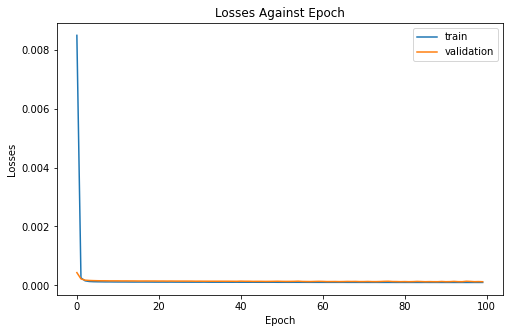

In [ ]:
#Plot the Losses against Epoch
plt.figure(figsize=(8,5))
plt.plot(train_losses,label='train')
plt.plot(valid_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()
plt.title("Losses Against Epoch")

Text(0.5, 1.0, 'Accuracy Against Epoch')

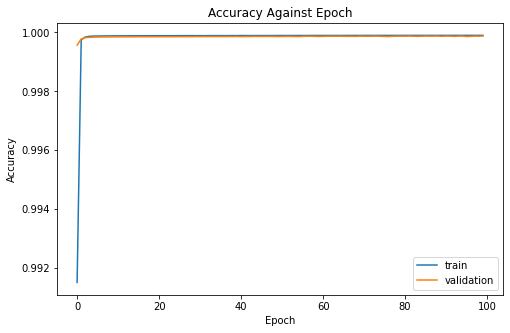

In [ ]:
#Plot the Dice against Epoch
plt.figure(figsize=(8,5))
plt.plot(train_metrics,label='train')
plt.plot(valid_metrics, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy Against Epoch")

In [ ]:
img, mask = iter(val_loader).next()

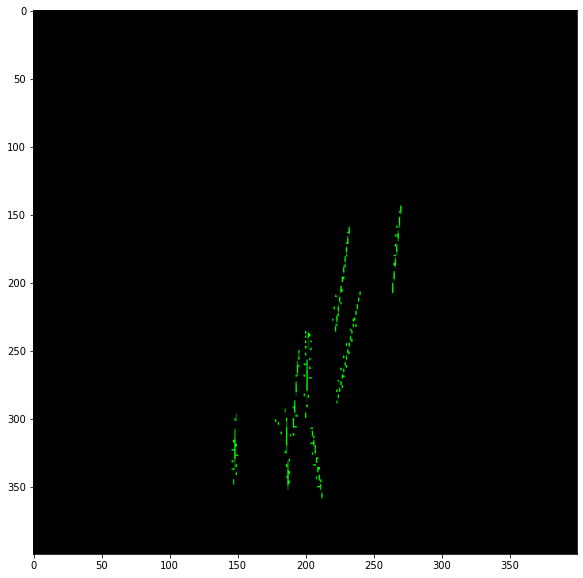

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(mask[1,:,:,:].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


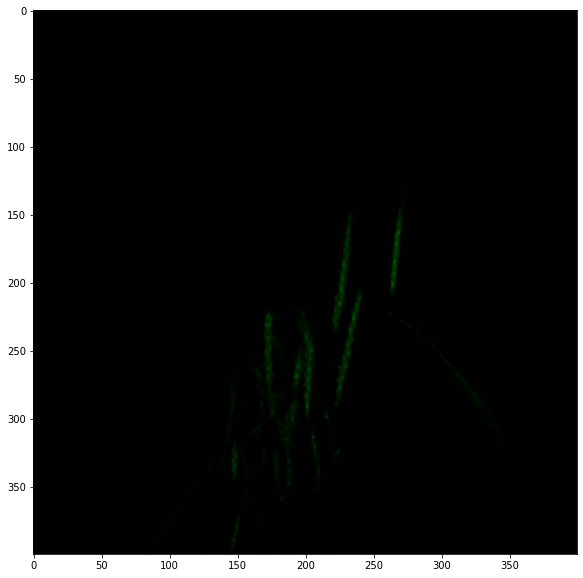

In [ ]:
out = model(img.to('cuda'))
image = out[1,:,:,:].cpu().detach()
plt.figure(figsize=(10,10))
plt.imshow(image.permute(1, 2, 0))


In [ ]:
#model =  UNet(n_channels=3,n_classes=3).to('cuda')
#model = FCNN(n_classes=3).to('cuda')
#model.load_state_dict(torch.load('/content/model400_20.pt'))
#model

# Testing

In [ ]:
def test(img_path,model=model):
  img = imageio.imread(img_path)
  img = cv2.resize(img, dsize=(400, 400)) 
  aug = transforms.Compose([transforms.ToTensor()]) 
  img = aug(img)
  img = img.unsqueeze(0)
  img = img.cuda()
  out =model(img)
  
  plt.figure(figsize=(10,10))
  plt.imshow(out.squeeze().cpu().detach().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


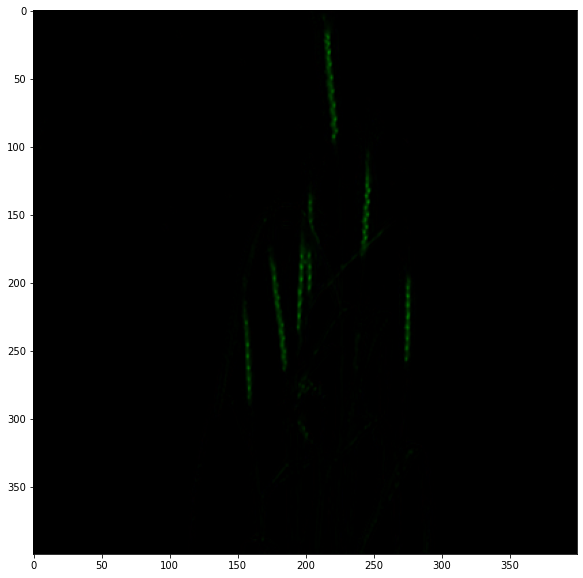

In [ ]:
test('/content/drive/My Drive/input/acid-dataset-validation/wheat2017/wheat2017_0017/wheat2017_0017.jpg')